In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from functions import preprocess_tweet,replace_emoji,analyze_sentiment,create_tokenize_function
import re
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from transformers import *
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForMaskedLM
import seaborn as sns
import json
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from itertools import combinations
from functions_analysis import *
# Suppress the specific FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)
pd.set_option('max_colwidth', 800)

# Dataset preparation

In [3]:
# model = BertForSequenceClassification.from_pretrained("./model_output_bert_1_uncased_epoch2")
# tokenizer = BertTokenizer.from_pretrained("./model_output_bert_1_uncased_epoch2")
# with open("./model_output/training_args.json", 'r') as f:
#     training_args = TrainingArguments(**json.load(f))


# trainer = Trainer(
#     model=model,
#     args=training_args
# )
# df_processed = pd.read_csv('df_processed2.csv')
# df_processed['Date'] = pd.to_datetime(df_processed['created_at'], errors='coerce')
# df_processed =df_processed[~df_processed['text'].isna()]
# df_processed['sentiment_analysis'] = df_processed['text'].apply(lambda x: analyze_sentiment(text=x,tokenizer=tokenizer,model=model))
# df_processed[['sentiment', 'confidence']] = pd.DataFrame(df_processed['sentiment_analysis'].tolist())
# df_processed.to_csv('dataset2_analyzed.csv')


In [22]:
# 1. Load the dataset
dataset_analyzed = pd.read_csv('dataset2_analyzed.csv')

# 2. Drop unwanted columns
columns = [col for col in dataset_analyzed.columns if col not in ['Unnamed: 0', 'Unnamed: 0.1']]
dataset_analyzed = dataset_analyzed[columns]

# 3. Drop rows with any missing values
dataset_analyzed.dropna(inplace=True)

# 4. Parse 'created_at' as UTC datetime (handles tz-aware and tz-naive values safely)
dataset_analyzed['created_at'] = pd.to_datetime(dataset_analyzed['created_at'], errors='raise', utc=True)

# 5. Convert to Warsaw time
dataset_analyzed['created_at'] = dataset_analyzed['created_at'].dt.tz_convert('Europe/Warsaw')

# 6. Create 'Date' column (date only, no time, tz-naive)
dataset_analyzed['Date'] = dataset_analyzed['created_at'].dt.normalize().dt.tz_localize(None)


In [23]:
dataset_analyzed.head()

,created_at,text,company,view_count,retweet_count,user_name,sentiment_analysis,sentiment,confidence,Date
0,2023-06-07 00:26:26+02:00,siedziałam dziś 3 godziny i wystawiałam rzeczy na allegro lokalnie ale chyba nie idzie mi tragicznie do tej pory zarobiłam już 3k jak sprzeda się reszta to będzie drugie tyle trzymajcie kciuki plz,ALLEGRO,717.0,0,Papużka 🦜,"('Negative', 0.5074750781059265)",Negative,0.507475,2023-06-07
1,2023-06-07 00:00:21+02:00,polaroid okulary przeciwsłoneczne 10899 zł w polsce sprawdź ceny na sprawdź ceny na,ALLEGRO,14.0,0,Janusz Cebula,"('Positive', 0.5837035775184631)",Positive,0.583704,2023-06-07
2,2023-06-06 23:53:58+02:00,tez sobie chcialam zamówić lomo kidsow z allegro ale właśnie wtedy mnie dopadły myśli że przypał bo nieoficjalne ale z drugiej strony przecież nie ma w tym nic złego bo one i tak są piękne,ALLEGRO,11.0,0,"𝓥𝓲𝓬 ✧ | 𝐒𝐀𝐖 𝐏𝐈𝐗𝐘, 𝐎𝐍𝐄𝐔𝐒 |","('Neutral', 0.41323935985565186)",Neutral,0.413239,2023-06-06
3,2023-06-06 23:00:38+02:00,xiaomi redmi 10 5g 464gb srebrny 53075 zł aplikacja allegro sprawdź ceny na na,ALLEGRO,14.0,0,Janusz Cebula,"('Positive', 0.585035502910614)",Positive,0.585036,2023-06-06
4,2023-06-06 22:46:25+02:00,ciekawa funkcja że na zaciąga widgety z ios i ipados można ich użyć na macos ten konkretny to status przesyłek z może to być fajna informacja znajdująca się prosto na pulpicie komputeraczekam na taki sam od,ALLEGRO,57.0,0,Adrian Cisowski,"('Positive', 0.39778000116348267)",Positive,0.397780,2023-06-06


In [26]:
print(dataset_analyzed['company'].unique())

['ALLEGRO' 'CCC' 'CDR' 'XTB' 'MENTZEN']


In [188]:
#STOCK DATA PROCESSING
companies_stock_data = {}
companies =  list(dataset_analyzed['company'].unique())

for company in companies:
    df = pd.read_csv(f'Stock_data/{company}.csv')
    df['Data'] = pd.to_datetime(df['Data'])
    df.sort_values(by = 'Data')

    # Calculate returns and other metrics
    df['Return'] = df['Zamkniecie'].pct_change()
    df['Same_day_return'] = (df['Zamkniecie'] - df['Otwarcie'])/ df['Otwarcie']
    df['Overnight_return'] = (df['Zamkniecie'] - df['Otwarcie'].shift(1))/ df['Zamkniecie']
    df['Change'] = df['Zamkniecie'] - df['Zamkniecie'].shift(1)

    df['Direction'] = df['Return'].apply(lambda x: 1 if x >0 else -1 )
    

    df['volatility'] = (
    (df['Najwyzszy'] - df['Najnizszy']) / df['Otwarcie']
    ).where(df['Otwarcie'] != 0, 0)

    
    # Create a complete date range from the minimum to maximum date in the dataset
    date_range = pd.date_range(start=df['Data'].min(), 
                          end=df['Data'].max(), 
                          freq='D')  
    
    # Reindex with complete date range
    df = df.set_index('Data').reindex(date_range).reset_index()
    df = df.rename(columns={'index': 'Date'})
    df['Date'] = pd.to_datetime(df['Date'], errors='raise')
    df['weekday'] = df['Date'].dt.day_name()
    df['company'] = company
    df['is_trading_day'] = df['Zamkniecie'].notna()
    companies_stock_data[company] = df



In [190]:
# TWEET DATA PROCESSING
aggregations = {
    'view_count': 'sum', 
    'retweet_count': 'sum',
    'sentiment': 'count'
    }
grouped_metrics = dataset_analyzed.groupby(['company','Date', 'sentiment']).agg(aggregations).unstack().reset_index()
grouped_metrics = grouped_metrics.fillna(0)
# Rename columns for clarity
grouped_metrics.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in grouped_metrics.columns]
grouped_metrics = grouped_metrics.rename(columns = {'company_':'company','Date_':'Date','sentiment_Negative':'Negative',
                                                       'sentiment_Neutral':'Neutral','sentiment_Positive':'Positive'})
grouped_metrics['sentiment_score'] =grouped_metrics['Positive'] - grouped_metrics['Negative']
grouped_metrics['sentiment_score_views'] = grouped_metrics['view_count_Positive'] - grouped_metrics['view_count_Negative']
grouped_metrics['tweet_volume'] = grouped_metrics['Positive'] + grouped_metrics['Neutral'] + grouped_metrics['Negative']
grouped_metrics['total_views'] =  grouped_metrics['view_count_Negative'] + grouped_metrics['view_count_Neutral'] + grouped_metrics['view_count_Positive']
grouped_metrics['sentiment_polarity'] = (
        (grouped_metrics['Positive'] - grouped_metrics['Negative']) / 
        (grouped_metrics['Positive'] + grouped_metrics['Negative'])
    ).where(
        (grouped_metrics['Positive'] + grouped_metrics['Negative']) != 0, 
        0
    ) 
display(grouped_metrics.head())

,company,Date,view_count_Negative,view_count_Neutral,view_count_Positive,retweet_count_Negative,retweet_count_Neutral,retweet_count_Positive,Negative,Neutral,Positive,sentiment_score,sentiment_score_views,tweet_volume,total_views,sentiment_polarity
0,ALLEGRO,2023-05-31,22904.0,4341.0,33285.0,28.0,1.0,106.0,39.0,30.0,9.0,-30.0,10381.0,78.0,60530.0,-0.625000
1,ALLEGRO,2023-06-01,21180.0,13280.0,836.0,0.0,4.0,0.0,23.0,34.0,15.0,-8.0,-20344.0,72.0,35296.0,-0.210526
2,ALLEGRO,2023-06-02,15433.0,196910.0,3750.0,22.0,144.0,1.0,42.0,32.0,18.0,-24.0,-11683.0,92.0,216093.0,-0.400000
3,ALLEGRO,2023-06-03,75296.0,52734.0,1428.0,3.0,0.0,0.0,44.0,33.0,8.0,-36.0,-73868.0,85.0,129458.0,-0.692308
4,ALLEGRO,2023-06-04,26657.0,9845.0,2430.0,6.0,4.0,0.0,43.0,41.0,13.0,-30.0,-24227.0,97.0,38932.0,-0.535714


In [193]:
max_min_dates = {}
for company in companies:
    filtered = grouped_metrics[grouped_metrics['company']== company]
    filtered['Date'].max()
    filtered['Date'].min()
    max_min_dates[company] = {
        'max_date': filtered['Date'].max(),
        'min_date': filtered['Date'].min()
    }

In [ ]:
companies_data_daily = {}
selected_columns = ['company', 'Date','weekday','is_trading_day' , 'Negative', 'Neutral', 'Positive', 'sentiment_score','sentiment_polarity', 'tweet_volume','view_count_Negative', 'view_count_Neutral', 'view_count_Positive','total_views','sentiment_score_views', 'retweet_count_Negative', 'retweet_count_Neutral', 'retweet_count_Positive', 'Otwarcie', 'Najwyzszy', 'Najnizszy', 'Zamkniecie', 'Wolumen','volatility', 'Return','Direction','Change']

for company, df in companies_stock_data.items():
    
    df_with_prices = pd.merge(df,grouped_metrics, left_on = ['Date','company'],right_on=['Date','company'],how='left')
    # CHOOSE COLUMNS
    df_with_prices = df_with_prices[selected_columns]
    companies_data_daily[company] = df_with_prices

In [74]:
stock_columns = ['Otwarcie', 'Najwyzszy', 'Najnizszy', 'Zamkniecie', 'Wolumen', 'Return','volatility','Direction','Change']
tweet_columns = ['view_count_Negative', 'view_count_Neutral', 'view_count_Positive', 
                 'retweet_count_Negative', 'retweet_count_Neutral', 'retweet_count_Positive',
                 'tweet_volume', 'sentiment_score', 'sentiment_score_views','total_views','sentiment_polarity']


In [111]:
def create_prediction_lags(df, tweet_col=[], max_lags=5):
    trading_days = df[df['is_trading_day']].copy().reset_index(drop=True)
    
    for col in tweet_col:
        for lag in range(1, max_lags + 1):
            lagged_values = []
            
            for idx, row in trading_days.iterrows():
                current_date = row['Date']
                target_date = current_date - pd.Timedelta(days=lag)
                
                # Get tweet for exact target date
                tweet_row = df[df['Date'] == target_date]
                
                if len(tweet_row) > 0 and not pd.isna(tweet_row[col].iloc[0]):
                    lagged_values.append(tweet_row[col].iloc[0])
                else:
                    lagged_values.append(np.nan)
            
            trading_days[f'{col}_lag_{lag}'] = lagged_values
    
    return trading_days

In [113]:
companies_data_daily_final = {}
for company, df in companies_data_daily.items():
    companies_data_daily_final[company] = create_prediction_lags(df, tweet_col=tweet_columns, max_lags=5)

In [115]:
tweet_columns_with_lagged = [x for x in companies_data_daily_final['ALLEGRO'] if x.startswith(tuple(tweet_columns))]

# Analysis

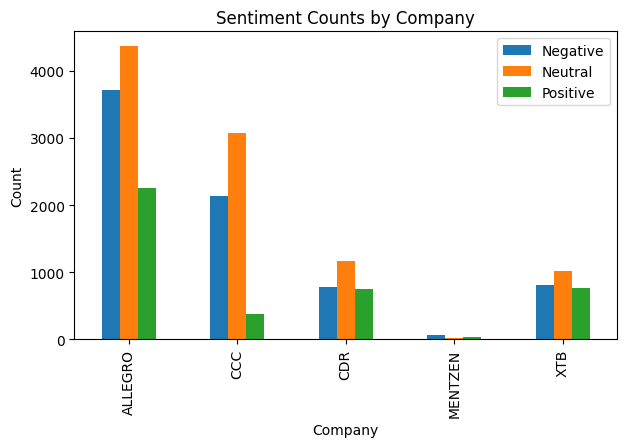

In [17]:
selected_columns = ['Negative','Neutral','Positive'] 
counts = merged_daily.groupby(['company'])[selected_columns].sum()

counts.plot(kind='bar', figsize=(7, 4))
plt.xlabel('Company')
plt.ylabel('Count')
plt.title('Sentiment Counts by Company')
plt.show()


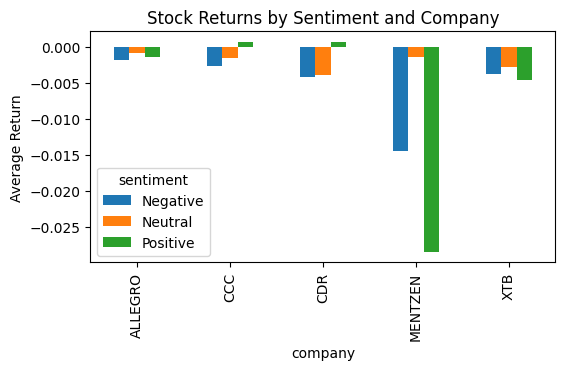

In [18]:
sentiment_returns = df_with_prices.groupby(['company', 'sentiment'])['Return'].mean().unstack()
sentiment_returns.plot(kind='bar', figsize=(6,3))
plt.title('Stock Returns by Sentiment and Company')
plt.ylabel('Average Return')
plt.show()


In [31]:
correlation_results = {}


for company in companies:
    correlation_results[company] = {}
    df = merged_daily[merged_daily['company'] == company]
    df_results = []  # Collect results for all lags
    x = df[stock_columns]
    y = df[tweet_columns]
    
    # Calculate correlation matrix
    corr_matrix = pd.concat([x, y], axis=1).corr()
    
    # Extract correlations between tweet_columns and stock_columns
    correlations = corr_matrix.loc[tweet_columns, stock_columns].reset_index()
    correlations = correlations.melt(id_vars='index', var_name='pair', value_name=f'Correlation')
    df_results.append(correlations)
    
    # Combine all lag correlation results
    df_combined = df_results[0]
    

    
    df_combined = df_combined.sort_values('Correlation', key=lambda x: abs(x), ascending=False)
    
    correlation_results[company] = df_combined


In [32]:
correlation_results['ALLEGRO'].head(10)

,index,pair,Correlation
219,retweet_count_Positive,Wolumen,0.411778
214,view_count_Positive,Wolumen,0.396187
178,view_count_Positive_lg_3,Wolumen,0.316696
188,view_count_Neutral_lg_2,Wolumen,0.311983
215,total_views,Wolumen,0.298634
216,sentiment_score_views,Wolumen,0.271453
354,view_count_Positive_lg_3,Change,-0.270604
230,sentiment_polarity_lg_3,Return,-0.267481
222,view_count_Positive_lg_3,Return,-0.258164
362,sentiment_polarity_lg_3,Change,-0.246360


In [33]:
correlation_results['CCC'].head(10)

,index,pair,Correlation
165,sentiment_score,Zamkniecie,0.456131
77,sentiment_score,Najwyzszy,0.455051
121,sentiment_score,Najnizszy,0.450728
123,tweet_volume,Najnizszy,-0.440120
167,tweet_volume,Zamkniecie,-0.437271
33,sentiment_score,Otwarcie,0.432927
72,tweet_volume_lg_1,Najwyzszy,-0.419250
79,tweet_volume,Najwyzszy,-0.414717
35,tweet_volume,Otwarcie,-0.411079
160,tweet_volume_lg_1,Zamkniecie,-0.407877


In [34]:
correlation_results['CDR'].head(10)

,index,pair,Correlation
299,tweet_volume,volatility,0.716827
211,tweet_volume,Wolumen,0.670567
301,view_count_Neutral,volatility,0.652114
214,view_count_Positive,Wolumen,0.530581
213,view_count_Neutral,Wolumen,0.528002
302,view_count_Positive,volatility,0.469991
303,total_views,volatility,0.438461
215,total_views,Wolumen,0.373730
193,tweet_volume_lg_2,Wolumen,0.338478
189,view_count_Positive_lg_2,Wolumen,0.334233


In [35]:
correlation_results['MENTZEN'].head(10)

,index,pair,Correlation
212,view_count_Negative,Wolumen,0.876956
198,view_count_Negative_lg_1,Wolumen,0.829992
219,retweet_count_Positive,Wolumen,0.779525
215,total_views,Wolumen,0.728055
80,view_count_Negative,Najwyzszy,0.679212
303,total_views,volatility,0.667465
168,view_count_Negative,Zamkniecie,0.660131
300,view_count_Negative,volatility,0.655000
206,sentiment_score_views_lg_1,Wolumen,-0.634426
286,view_count_Negative_lg_1,volatility,0.623412


In [36]:
correlation_results['XTB'].head(10)

,index,pair,Correlation
299,tweet_volume,volatility,0.531696
212,view_count_Negative,Wolumen,0.480638
211,tweet_volume,Wolumen,0.478164
300,view_count_Negative,volatility,0.343372
297,sentiment_score,volatility,-0.274821
194,sentiment_score_lg_2,Wolumen,-0.274086
217,retweet_count_Negative,Wolumen,0.269619
298,sentiment_polarity,volatility,-0.257266
301,view_count_Neutral,volatility,0.253990
282,sentiment_score_lg_2,volatility,-0.247305


In [44]:
all_results = []

for company in companies:
    print(company)
    company_data = merged_daily[merged_daily['company'] == company]
    results = fit_regressions(company_data, stock_columns, tweet_columns)
    results['company'] = company
    all_results.append(results)

# Concatenate all results
regression_results = pd.concat(all_results, ignore_index=True)

# Display results, sorted by R-squared
regression_results = regression_results.sort_values(by='R-squared', ascending=False)
regression_results

ALLEGRO
view_count_Negative_lg_3
view_count_Neutral_lg_3
view_count_Positive_lg_3
retweet_count_Negative_lg_3
retweet_count_Neutral_lg_3
retweet_count_Positive_lg_3
tweet_volume_lg_3
sentiment_score_lg_3
sentiment_score_views_lg_3
total_views_lg_3
sentiment_polarity_lg_3
view_count_Negative_lg_2
view_count_Neutral_lg_2
view_count_Positive_lg_2
retweet_count_Negative_lg_2
retweet_count_Neutral_lg_2
retweet_count_Positive_lg_2
tweet_volume_lg_2
sentiment_score_lg_2
sentiment_score_views_lg_2
total_views_lg_2
sentiment_polarity_lg_2
view_count_Negative_lg_1
view_count_Neutral_lg_1
view_count_Positive_lg_1
retweet_count_Negative_lg_1
retweet_count_Neutral_lg_1
retweet_count_Positive_lg_1
tweet_volume_lg_1
sentiment_score_lg_1
sentiment_score_views_lg_1
total_views_lg_1
sentiment_polarity_lg_1
sentiment_score
sentiment_polarity
tweet_volume
view_count_Negative
view_count_Neutral
view_count_Positive
total_views
sentiment_score_views
retweet_count_Negative
retweet_count_Neutral
retweet_count_

e:\Project\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
e:\Project\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


tweet_volume_lg_2
sentiment_score_lg_2
sentiment_score_views_lg_2
total_views_lg_2
sentiment_polarity_lg_2
view_count_Negative_lg_1
view_count_Neutral_lg_1
view_count_Positive_lg_1
retweet_count_Negative_lg_1
retweet_count_Neutral_lg_1
retweet_count_Positive_lg_1
tweet_volume_lg_1
sentiment_score_lg_1
sentiment_score_views_lg_1
total_views_lg_1
sentiment_polarity_lg_1
sentiment_score
sentiment_polarity
tweet_volume
view_count_Negative
view_count_Neutral
view_count_Positive
total_views
sentiment_score_views
retweet_count_Negative
retweet_count_Neutral
retweet_count_Positive
view_count_Negative_lg_3
view_count_Neutral_lg_3
view_count_Positive_lg_3
retweet_count_Negative_lg_3
retweet_count_Neutral_lg_3
retweet_count_Positive_lg_3
tweet_volume_lg_3
sentiment_score_lg_3
sentiment_score_views_lg_3
total_views_lg_3
sentiment_polarity_lg_3
view_count_Negative_lg_2
view_count_Neutral_lg_2
view_count_Positive_lg_2
retweet_count_Negative_lg_2
retweet_count_Neutral_lg_2
retweet_count_Positive_lg_2

e:\Project\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


total_views_lg_1
sentiment_polarity_lg_1
sentiment_score
sentiment_polarity
tweet_volume
view_count_Negative
view_count_Neutral
view_count_Positive
total_views
sentiment_score_views
retweet_count_Negative
retweet_count_Neutral
retweet_count_Positive
view_count_Negative_lg_3
view_count_Neutral_lg_3
view_count_Positive_lg_3
retweet_count_Negative_lg_3
retweet_count_Neutral_lg_3
retweet_count_Positive_lg_3
tweet_volume_lg_3
sentiment_score_lg_3
sentiment_score_views_lg_3
total_views_lg_3
sentiment_polarity_lg_3
view_count_Negative_lg_2
view_count_Neutral_lg_2
view_count_Positive_lg_2
retweet_count_Negative_lg_2
retweet_count_Neutral_lg_2
retweet_count_Positive_lg_2
tweet_volume_lg_2
sentiment_score_lg_2
sentiment_score_views_lg_2
total_views_lg_2
sentiment_polarity_lg_2
view_count_Negative_lg_1
view_count_Neutral_lg_1
view_count_Positive_lg_1
retweet_count_Negative_lg_1
retweet_count_Neutral_lg_1
retweet_count_Positive_lg_1
tweet_volume_lg_1
sentiment_score_lg_1
sentiment_score_views_lg_1

e:\Project\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
e:\Project\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


view_count_Positive
total_views
sentiment_score_views
retweet_count_Negative
retweet_count_Neutral
retweet_count_Positive
view_count_Negative_lg_3
view_count_Neutral_lg_3
view_count_Positive_lg_3
retweet_count_Negative_lg_3
retweet_count_Neutral_lg_3
retweet_count_Positive_lg_3
tweet_volume_lg_3
sentiment_score_lg_3
sentiment_score_views_lg_3
total_views_lg_3
sentiment_polarity_lg_3
view_count_Negative_lg_2
view_count_Neutral_lg_2
view_count_Positive_lg_2
retweet_count_Negative_lg_2
retweet_count_Neutral_lg_2
retweet_count_Positive_lg_2
tweet_volume_lg_2
sentiment_score_lg_2
sentiment_score_views_lg_2
total_views_lg_2
sentiment_polarity_lg_2
view_count_Negative_lg_1
view_count_Neutral_lg_1
view_count_Positive_lg_1
retweet_count_Negative_lg_1
retweet_count_Neutral_lg_1
retweet_count_Positive_lg_1
tweet_volume_lg_1
sentiment_score_lg_1
sentiment_score_views_lg_1
total_views_lg_1
sentiment_polarity_lg_1
sentiment_score
sentiment_polarity
tweet_volume
view_count_Negative
view_count_Neutral

e:\Project\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
e:\Project\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


retweet_count_Neutral_lg_3
retweet_count_Positive_lg_3
tweet_volume_lg_3
sentiment_score_lg_3
sentiment_score_views_lg_3
total_views_lg_3
sentiment_polarity_lg_3
view_count_Negative_lg_2
view_count_Neutral_lg_2
view_count_Positive_lg_2
retweet_count_Negative_lg_2
retweet_count_Neutral_lg_2
retweet_count_Positive_lg_2
tweet_volume_lg_2
sentiment_score_lg_2
sentiment_score_views_lg_2
total_views_lg_2
sentiment_polarity_lg_2
view_count_Negative_lg_1
view_count_Neutral_lg_1
view_count_Positive_lg_1
retweet_count_Negative_lg_1
retweet_count_Neutral_lg_1
retweet_count_Positive_lg_1
tweet_volume_lg_1
sentiment_score_lg_1
sentiment_score_views_lg_1
total_views_lg_1
sentiment_polarity_lg_1
sentiment_score
sentiment_polarity
tweet_volume
view_count_Negative
view_count_Neutral
view_count_Positive
total_views
sentiment_score_views
retweet_count_Negative
retweet_count_Neutral
retweet_count_Positive
view_count_Negative_lg_3
view_count_Neutral_lg_3
view_count_Positive_lg_3
retweet_count_Negative_lg_3

e:\Project\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


retweet_count_Negative_lg_2
retweet_count_Neutral_lg_2
retweet_count_Positive_lg_2
tweet_volume_lg_2
sentiment_score_lg_2
sentiment_score_views_lg_2
total_views_lg_2
sentiment_polarity_lg_2
view_count_Negative_lg_1
view_count_Neutral_lg_1
view_count_Positive_lg_1
retweet_count_Negative_lg_1
retweet_count_Neutral_lg_1
retweet_count_Positive_lg_1
tweet_volume_lg_1
sentiment_score_lg_1
sentiment_score_views_lg_1
total_views_lg_1
sentiment_polarity_lg_1
sentiment_score
sentiment_polarity
tweet_volume
view_count_Negative
view_count_Neutral
view_count_Positive
total_views
sentiment_score_views
retweet_count_Negative
retweet_count_Neutral
retweet_count_Positive


e:\Project\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,Stock Variable,Tweet Variable,R-squared,Adj R-squared,Coefficient,P-value,Residuals Normality P-value,Homoscedasticity P-value,Durbin-Watson,VIF,Sample Size,Outliers Removed,company
1799,Wolumen,total_views,0.873,0.866,0.726,0.00000,0.36966,0.31595,1.797,1.0,21,1,MENTZEN
1798,Wolumen,view_count_Positive,0.772,0.760,2.787,0.00000,0.00001,0.15819,1.377,1.0,21,1,MENTZEN
1791,Wolumen,total_views_lg_1,0.693,0.676,1.165,0.00000,0.00417,0.53231,0.888,1.0,21,1,MENTZEN
1886,volatility,view_count_Positive,0.629,0.610,0.000,0.00002,0.32857,0.16057,1.268,1.0,21,1,MENTZEN
1976,Change,sentiment_score_views,0.619,0.599,-0.000,0.00002,0.87690,0.05119,1.437,1.0,21,1,MENTZEN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,Direction,total_views,0.000,-0.010,0.000,0.95096,0.00000,0.00000,1.961,1.0,104,1,CDR
234,Return,retweet_count_Negative_lg_2,0.000,-0.010,0.000,0.86762,0.00268,0.00000,2.139,1.0,103,2,ALLEGRO
235,Return,retweet_count_Neutral_lg_2,0.000,-0.010,0.000,0.93619,0.00496,0.00001,2.144,1.0,103,2,ALLEGRO
478,Najwyzszy,view_count_Positive,0.000,-0.010,-0.000,0.87174,0.07089,0.01165,0.083,1.0,104,1,CCC


In [47]:
regression_results.groupby('company').head(2).sort_values(by=['company','R-squared'],ascending=False)

,Stock Variable,Tweet Variable,R-squared,Adj R-squared,Coefficient,P-value,Residuals Normality P-value,Homoscedasticity P-value,Durbin-Watson,VIF,Sample Size,Outliers Removed,company
1400,Wolumen,view_count_Negative,0.374,0.368,9.641,0.00000,0.00000,0.00000,2.084,1.0,102,2,XTB
1488,volatility,view_count_Negative,0.326,0.319,0.000,0.00000,0.00001,0.00000,1.672,1.0,102,2,XTB
1799,Wolumen,total_views,0.873,0.866,0.726,0.00000,0.36966,0.31595,1.797,1.0,21,1,MENTZEN
1798,Wolumen,view_count_Positive,0.772,0.760,2.787,0.00000,0.00001,0.15819,1.377,1.0,21,1,MENTZEN
1093,volatility,view_count_Neutral,0.520,0.516,0.000,0.00000,0.02049,0.00000,1.506,1.0,104,1,CDR
1095,volatility,total_views,0.461,0.456,0.000,0.00000,0.01058,0.00000,1.532,1.0,104,1,CDR
473,Najwyzszy,sentiment_score,0.224,0.216,0.179,0.00000,0.52691,0.00000,0.340,1.0,104,1,CCC
561,Zamkniecie,sentiment_score,0.216,0.209,0.175,0.00000,0.71524,0.00000,0.373,1.0,104,1,CCC
214,Wolumen,view_count_Positive,0.274,0.267,160.856,0.00000,0.00000,0.00000,1.595,1.0,102,3,ALLEGRO
302,volatility,view_count_Positive,0.139,0.130,0.000,0.00012,0.00007,0.00000,1.577,1.0,102,3,ALLEGRO


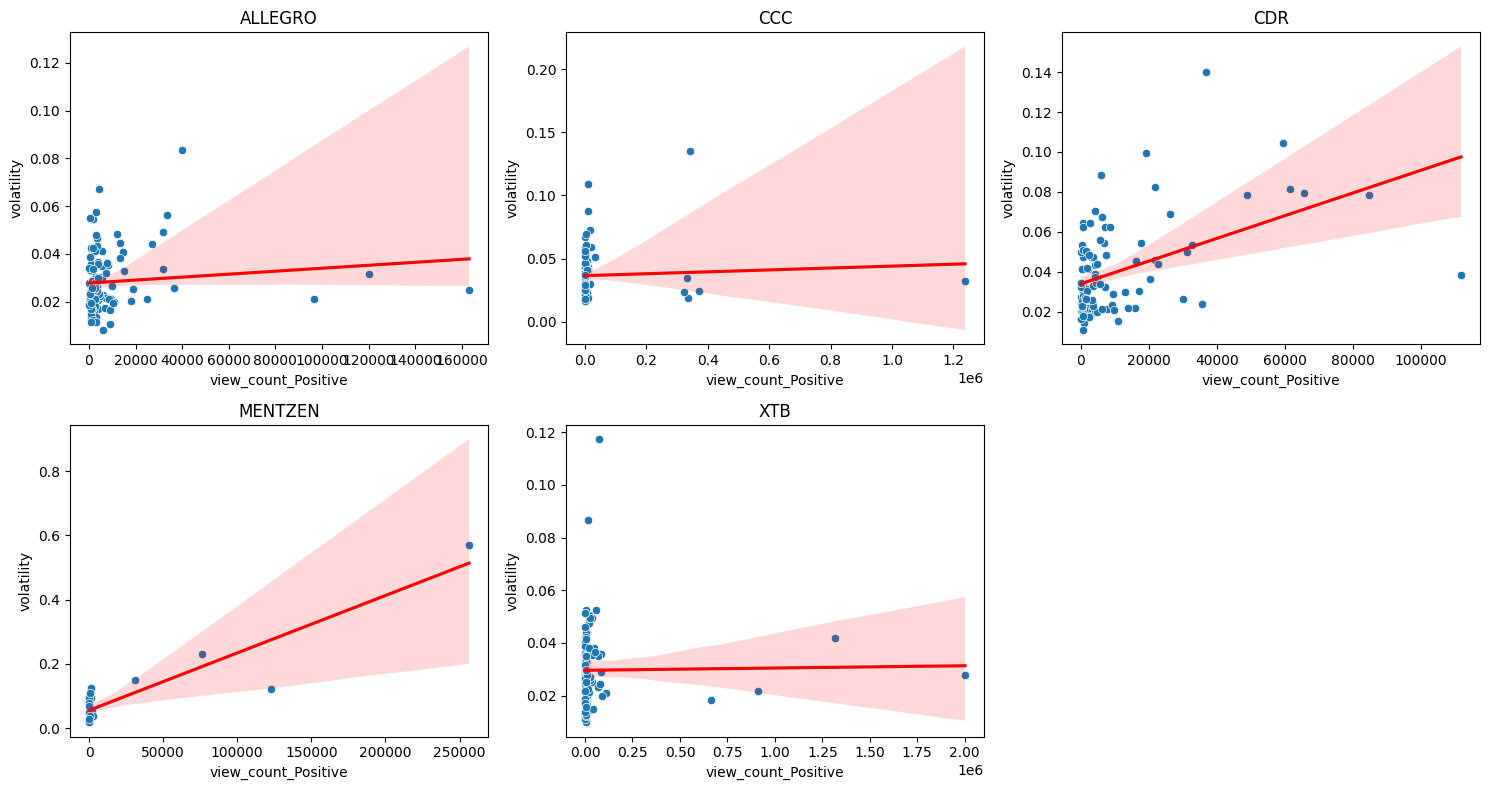

In [18]:
companies = merged_daily['company'].unique()
n_companies = len(companies)
n_cols = 3
n_rows = (n_companies - 1) // n_cols + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i, company in enumerate(companies):
    company_data = merged_daily[merged_daily['company'] == company]
    sns.scatterplot(data=company_data, x='view_count_Positive', y='volatility', ax=axes[i])
    sns.regplot(data=company_data, x='view_count_Positive', y='volatility', scatter=False, ax=axes[i], color='red')
    axes[i].set_title(company)
    axes[i].set_xlabel('view_count_Positive')
    axes[i].set_ylabel('volatility')

for i in range(n_companies, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('sentiment_vs_return_by_company.png')
plt.show()

In [50]:
def find_best_combination(df, stock_column, tweet_columns, max_features=3):
    best_result = {
        'R-squared': 0,
        'Combination': None,
        'Model': None
    }

    for n in range(1, min(max_features, len(tweet_columns)) + 1):
        for combo in combinations(tweet_columns, n):
            X = df[list(combo)]
            y = df[stock_column]
            
            valid_data = pd.concat([X, y], axis=1).dropna()
            X = valid_data[list(combo)]
            y = valid_data[stock_column]

            z_scores = np.abs(stats.zscore(X))
            outlier_mask = (z_scores < 3).all(axis=1)
            X = X[outlier_mask]
            y = y[outlier_mask]
            
            
            X = sm.add_constant(X)
            model = sm.OLS(y, X).fit()
            _, normality_pvalue = stats.normaltest(model.resid)
            
            if model.rsquared > best_result['R-squared']:
                best_result = {
                    'R-squared': model.rsquared,
                    'Combination': combo,
                    'Model': model,
                    'Residuals Normality P-value': normality_pvalue
                }
    
    return best_result

def analyze_stocks(df, stock_columns, tweet_columns, max_features=3):
    results = []
    
    for stock_var in stock_columns:
        print(f"Analyzing {stock_var}...")
        best = find_best_combination(df, stock_var, tweet_columns, max_features)
        
        result = {
            'Stock Variable': stock_var,
            'Best Tweet Varaibles Combination': best['Combination'],
            'R-squared': best['R-squared'].round(3),
            'Residuals Normality P-value': best['Residuals Normality P-value']
        }
        
        for feature in best['Combination']:
            result[f'Coefficient_{feature}'] = best['Model'].params[feature].round(10)
            result[f'P-value_{feature}'] = best['Model'].pvalues[feature].round(5)
        
        results.append(result)
    
    return results

all_results = {}

for company in companies:
    print(f"\nAnalyzing company: {company}")
    company_data = merged_daily[merged_daily['company'] == company]
    results = analyze_stocks(company_data, stock_columns, tweet_columns)
    all_results[company] = results


#final_results = pd.concat(all_results, ignore_index=True)


Analyzing company: ALLEGRO
Analyzing Otwarcie...
Analyzing Najwyzszy...
Analyzing Najnizszy...
Analyzing Zamkniecie...
Analyzing Wolumen...
Analyzing Return...
Analyzing volatility...
Analyzing Direction...
Analyzing Change...

Analyzing company: CCC
Analyzing Otwarcie...


KeyboardInterrupt: 

In [51]:
all_results['ALLEGRO']

[{'Stock Variable': 'Otwarcie',
  'Best Tweet Varaibles Combination': ('retweet_count_Positive_lg_3',
   'view_count_Positive_lg_2',
   'total_views_lg_2'),
  'R-squared': 0.097,
  'Residuals Normality P-value': 0.581192942439036,
  'Coefficient_retweet_count_Positive_lg_3': 0.1033331796,
  'P-value_retweet_count_Positive_lg_3': 0.09386,
  'Coefficient_view_count_Positive_lg_2': -8.24856e-05,
  'P-value_view_count_Positive_lg_2': 0.00493,
  'Coefficient_total_views_lg_2': 1.63606e-05,
  'P-value_total_views_lg_2': 0.07372},
 {'Stock Variable': 'Najwyzszy',
  'Best Tweet Varaibles Combination': ('view_count_Positive_lg_2',
   'view_count_Negative_lg_1',
   'retweet_count_Positive_lg_1'),
  'R-squared': 0.087,
  'Residuals Normality P-value': 0.16354160757635788,
  'Coefficient_view_count_Positive_lg_2': -5.29779e-05,
  'P-value_view_count_Positive_lg_2': 0.04378,
  'Coefficient_view_count_Negative_lg_1': 2.33455e-05,
  'P-value_view_count_Negative_lg_1': 0.08049,
  'Coefficient_retweet_

## Time Series Approach

### Linear modelling

In [55]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests

### ADF test for stationarity

In [59]:
# Initialize results dictionaries
stationarity_results = {}
granger_results = {}

# Lists of variables
STOCK = stock_columns
TWITTER = tweet_columns

# Stationarity threshold
stationarity_p_threshold = 0.05  # p-value threshold for stationarity
granger_p_threshold = 0.05  # p-value threshold for Granger causality

# Check stationarity for each variable
for company in merged_daily['company'].unique():
    stationarity_results[company] = {'STOCK': {}, 'TWITTER': {}}
    
    for variable in STOCK + TWITTER:
        # Extract data for the specific variable and company
        series = merged_daily[merged_daily['company'] == company][variable].dropna()
        
        # Perform the ADF test
        result = adfuller(series)
        p_value = result[1]
        
        # Store whether the variable is stationary
        category = 'STOCK' if variable in STOCK else 'TWITTER'
        stationarity_results[company][category][variable] = p_value < stationarity_p_threshold

stationarity_results


{'ALLEGRO': {'STOCK': {'Otwarcie': False,
   'Najwyzszy': False,
   'Najnizszy': False,
   'Zamkniecie': False,
   'Wolumen': True,
   'Return': True,
   'volatility': True,
   'Direction': True,
   'Change': True},
  'TWITTER': {'view_count_Negative': True,
   'view_count_Neutral': True,
   'view_count_Positive': True,
   'retweet_count_Negative': True,
   'retweet_count_Neutral': True,
   'retweet_count_Positive': True,
   'tweet_volume': True,
   'sentiment_score': True,
   'sentiment_score_views': True,
   'total_views': True,
   'sentiment_polarity': True}},
 'CCC': {'STOCK': {'Otwarcie': False,
   'Najwyzszy': False,
   'Najnizszy': False,
   'Zamkniecie': False,
   'Wolumen': True,
   'Return': True,
   'volatility': True,
   'Direction': True,
   'Change': True},
  'TWITTER': {'view_count_Negative': True,
   'view_count_Neutral': True,
   'view_count_Positive': True,
   'retweet_count_Negative': True,
   'retweet_count_Neutral': True,
   'retweet_count_Positive': False,
   'twe

In [60]:
stationary_stock = [var for var, is_stationary in results['STOCK'].items() if is_stationary]

TypeError: list indices must be integers or slices, not str

In [ ]:
stationary_twitter = [var for var, is_stationary in results['TWITTER'].items() if is_stationary]
stationary_twitter = [var for var in tweet_columns_with_lagged if var.startswith(tuple(stationary_twitter)) ]

In [150]:
from statsmodels.tsa.api import VAR

In [155]:
data.head(1)

,Change,retweet_count_Positive
488,-0.2295,87.0


In [156]:
X = sm.add_constant(data.iloc[:,1])
y = data.iloc[:,0]

# Fit model
model = sm.OLS(y, X).fit()

In [160]:
model.pvalues

const                     0.773628
retweet_count_Positive    0.538574
dtype: float64

In [148]:
# Perform Granger causality tests
for company, results in stationarity_results.items():
    granger_results[company] = {}
    
    # Get stationary variables for STOCK and TWITTER
    stationary_stock = [var for var, is_stationary in results['STOCK'].items() if is_stationary]
    stationary_twitter = [var for var, is_stationary in results['TWITTER'].items() if is_stationary]
    stationary_twitter = [var for var in tweet_columns_with_lagged if var.startswith(tuple(stationary_twitter)) ]
    
    # Check Granger causality for each pair of stationary variables
    for stock_var in stationary_stock:
        granger_results[company][stock_var] = {}
        
        for twitter_var in stationary_twitter:
            # Prepare data for the Granger test
            data = merged_daily[merged_daily['company'] == company].loc[:, [stock_var,twitter_var ]].dropna()
            
            # Perform the Granger causality test
            test_results = grangercausalitytests(data, maxlag=1, verbose=False)
            
            # Store significant results
            significant_lags = {
                lag: test_results[lag][0]['ssr_ftest'][1]
                for lag in test_results if test_results[lag][0]['ssr_ftest'][1] < granger_p_threshold
            }
            
            # Only include results if there are significant lags
            if significant_lags:
                granger_results[company][stock_var][twitter_var] = significant_lags
granger_results         

{'ALLEGRO': {'Wolumen': {'view_count_Positive_lg_1': {1: 3.0217086023562658e-05},
   'total_views_lg_1': {1: 0.026454254245903388},
   'sentiment_polarity_lg_1': {1: 0.041269877188931624},
   'view_count_Negative': {1: 0.00028456749877348557},
   'view_count_Positive': {1: 0.015326848256211074},
   'total_views': {1: 0.0035433805896904}},
  'Return': {'view_count_Negative': {1: 0.0013833660373269725},
   'view_count_Positive': {1: 0.002084934920138642},
   'total_views': {1: 0.001997165577537191}},
  'volatility': {'retweet_count_Negative_lg_3': {1: 0.006822185100869002}},
  'Direction': {'tweet_volume_lg_3': {1: 0.03505823034891886}},
  'Change': {'view_count_Negative': {1: 0.0012967139754467216},
   'view_count_Positive': {1: 0.002459933583273627},
   'total_views': {1: 0.002313230378445685}}},
 'CCC': {'Wolumen': {'retweet_count_Negative_lg_2': {1: 0.04956592429726201},
   'view_count_Positive_lg_1': {1: 0.0017508344885087718},
   'sentiment_score_views_lg_1': {1: 0.0024402395350741

In [64]:
# Perform Granger causality tests
granger_results_stock_causes_twitter= {}
for company, results in stationarity_results.items():
    granger_results_stock_causes_twitter[company] = {}
    
    # Get stationary variables for STOCK and TWITTER
    stationary_stock = [var for var, is_stationary in results['STOCK'].items() if is_stationary]
    stationary_twitter = [var for var, is_stationary in results['TWITTER'].items() if is_stationary]
    stationary_twitter = [var for var in tweet_columns_with_lagged if var.startswith(tuple(stationary_twitter)) ]
    # Check Granger causality for each pair of stationary variables
    for twitter_var in stationary_twitter:
    
        granger_results_stock_causes_twitter[company][twitter_var] = {}
        for stock_var in stationary_stock:
        
            # Prepare data for the Granger test
            data = merged_daily[merged_daily['company'] == company].loc[:, [twitter_var,stock_var ]].dropna()
            
            # Perform the Granger causality test
            test_results = grangercausalitytests(data, maxlag=1, verbose=False)
            
            # Store significant results
            significant_lags = {
                lag: test_results[lag][0]['ssr_ftest'][1]
                for lag in test_results if test_results[lag][0]['ssr_ftest'][1] < granger_p_threshold
            }
            
            # Only include results if there are significant lags
            if significant_lags:
                granger_results_stock_causes_twitter[company][twitter_var][stock_var] = significant_lags
granger_results_stock_causes_twitter         

{'ALLEGRO': {'view_count_Negative_lg_3': {},
  'view_count_Neutral_lg_3': {},
  'view_count_Positive_lg_3': {},
  'retweet_count_Negative_lg_3': {},
  'retweet_count_Neutral_lg_3': {},
  'retweet_count_Positive_lg_3': {},
  'tweet_volume_lg_3': {},
  'sentiment_score_lg_3': {},
  'sentiment_score_views_lg_3': {},
  'total_views_lg_3': {},
  'sentiment_polarity_lg_3': {},
  'view_count_Negative_lg_2': {},
  'view_count_Neutral_lg_2': {},
  'view_count_Positive_lg_2': {'Wolumen': {1: 0.0062353157275342385},
   'Return': {1: 0.02787597227285227},
   'Change': {1: 0.02095095831407479}},
  'retweet_count_Negative_lg_2': {},
  'retweet_count_Neutral_lg_2': {},
  'retweet_count_Positive_lg_2': {},
  'tweet_volume_lg_2': {},
  'sentiment_score_lg_2': {},
  'sentiment_score_views_lg_2': {},
  'total_views_lg_2': {},
  'sentiment_polarity_lg_2': {},
  'view_count_Negative_lg_1': {},
  'view_count_Neutral_lg_1': {'Wolumen': {1: 0.0008028875907430364}},
  'view_count_Positive_lg_1': {},
  'retweet

### Non - linear modelling

In [68]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input
from sklearn.preprocessing import MinMaxScaler

In [142]:
def prepare_data(df, tweet_cols, stock_cols):
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    # Reshape for LSTM: [samples, timesteps, features]
    X = scaler_X.fit_transform(df[tweet_cols]).reshape(len(df), -1, len(tweet_cols))
    y = scaler_y.fit_transform(df[stock_cols])
    
    return X, y, scaler_y

In [70]:
def create_model(input_shape, output_shape):
    model = Sequential([
        LSTM(128,  input_shape = input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(output_shape)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [144]:
def test_model_metrics(df, tweet_cols, stock_col, company):
    results = {}
    variants = ['tweet_var','no_tweet_var']
    df = df[df['company']==company]
    
    
    for variant in variants:
        if variant == 'no_tweet_var':
            input_cols = stock_col
        elif variant == 'tweet_var':
            input_cols = tweet_cols + stock_col

        X, y, scaler_y = prepare_data(df, input_cols, stock_col)

        # Train/test split
        split = int(0.8 * len(X))
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        # Create and train model
        model = create_model((1, len(input_cols)), len(stock_col))
        history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                          validation_split=0.1, verbose=0)

        # Evaluate
        predictions = model.predict(X_test)
        predictions = scaler_y.inverse_transform(predictions)
        true_values = scaler_y.inverse_transform(y_test)

        mse = np.mean((predictions - true_values) ** 2)
        results[variant]= {
            'mse': mse,
            'val_loss': min(history.history['val_loss'])
        }
    results['change'] = round(((results['tweet_var']['mse'] - results['no_tweet_var']['mse']) /results['no_tweet_var']['mse']) *100,2)
    return results



In [145]:
lstm_result = {}
for company in companies:
    lstm_result[company] = {}
    
    for stock_col in stationary_stock:
        lstm_result[company][stock_col] = {}
        
        for twitter_var in stationary_twitter:
           
            model_results = test_model_metrics(df=merged_daily,tweet_cols=[twitter_var],stock_col=[stock_col],company=company)
            lstm_result[company][stock_col][twitter_var] = model_results


e:\Project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


e:\Project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


e:\Project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


e:\Project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


e:\Project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


e:\Project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


e:\Project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


e:\Project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


e:\Project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


e:\Project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


e:\Project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


e:\Project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


e:\Project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


e:\Project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


e:\Project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


e:\Project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


e:\Project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


e:\Project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


e:\Project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


e:\Project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


e:\Project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


e:\Project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


e:\Project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


e:\Project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


e:\Project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


e:\Project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


e:\Project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

In [80]:
lstm_result

{'ALLEGRO': {'Wolumen': {'view_count_Negative_lg_3': {'tweet_var': {'mse': 11033281721225.977,
     'val_loss': 0.001496454467996955},
    'no_tweet_var': {'mse': 10710193678161.771,
     'val_loss': 0.0015161369228735566},
    'change': 3.0166405274536343},
   'view_count_Neutral_lg_3': {'tweet_var': {'mse': 10388105940426.99,
     'val_loss': 0.0015911769587546587},
    'no_tweet_var': {'mse': 10289407576003.678,
     'val_loss': 0.001522262580692768},
    'change': 0.9592230037955803},
   'view_count_Positive_lg_3': {'tweet_var': {'mse': 10748718289531.209,
     'val_loss': 0.001466725254431367},
    'no_tweet_var': {'mse': 10602044696961.197,
     'val_loss': 0.001465022680349648},
    'change': 1.3834462762834034},
   'retweet_count_Neutral_lg_3': {'tweet_var': {'mse': 10643676510486.074,
     'val_loss': 0.0013040059711784124},
    'no_tweet_var': {'mse': 10364799966153.7,
     'val_loss': 0.001487509347498417},
    'change': 2.6906119292513857},
   'retweet_count_Positive_lg_3':

In [173]:
lstm_result

{'ALLEGRO': {'Otwarcie': {'view_count_Negative': {'tweet_var': {'mse': 3.798445057387804,
     'val_loss': 0.012444321066141129},
    'no_tweet_var': {'mse': 4.107181369642801,
     'val_loss': 0.012139507569372654}},
   'view_count_Neutral': {'tweet_var': {'mse': 3.807671736824755,
     'val_loss': 0.013819866813719273},
    'no_tweet_var': {'mse': 3.778577914855873,
     'val_loss': 0.012081269174814224}},
   'view_count_Positive': {'tweet_var': {'mse': 3.899261942833284,
     'val_loss': 0.011995332315564156},
    'no_tweet_var': {'mse': 3.9070034652653125,
     'val_loss': 0.012321769259870052}},
   'retweet_count_Neutral': {'tweet_var': {'mse': 4.37739444584922,
     'val_loss': 0.012625779025256634},
    'no_tweet_var': {'mse': 3.757999353492981,
     'val_loss': 0.01196458749473095}},
   'retweet_count_Positive': {'tweet_var': {'mse': 4.064169821636629,
     'val_loss': 0.012133593671023846},
    'no_tweet_var': {'mse': 3.7349571230138565,
     'val_loss': 0.012022080831229687}}

ADD CLASSIFICATION

In [ ]:
def evaluate_lookbacks(df, tweet_cols, stock_cols, lookbacks=[1]):
    results = {}
    
    for lookback in lookbacks:
        X, y, scaler_y = prepare_data(df, tweet_cols, stock_cols, lookback)
        
        # Train/test split
        split = int(0.8 * len(X))
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]
        
        # Create and train model
        model = create_model((lookback, len(tweet_cols)), len(stock_cols))
        history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                          validation_split=0.1, verbose=0)
        
        # Evaluate
        predictions = model.predict(X_test)
        predictions = scaler_y.inverse_transform(predictions)
        true_values = scaler_y.inverse_transform(y_test)
        
        mse = np.mean((predictions - true_values) ** 2)
        results[lookback] = {
            'mse': mse,
            'val_loss': min(history.history['val_loss'])
        }
    
    return results



In [ ]:
def create_rolling_predictions(df, tweet_cols, stock_cols, test_days=100, lookback=7):
   # Split into train and test
   train_df = df[:-test_days]
   test_df = df[-test_days:]
   
   predictions = []
   
   for i in range(len(test_df)):
       # Get updated training data including latest actual values
       current_train = pd.concat([train_df, test_df[:i]])
       
       # Prepare data
       X, y, scaler_y = prepare_data(current_train, tweet_cols, stock_cols, lookback)
       
       # Train model
       model = create_model((lookback, len(tweet_cols)), len(stock_cols))
       model.fit(X, y, epochs=50, batch_size=32, verbose=0)
       
       # Predict next day
       last_sequence = scaler_X.transform(current_train[tweet_cols].tail(lookback))
       pred = model.predict(last_sequence.reshape(1, lookback, -1))
       pred = scaler_y.inverse_transform(pred)[0]
       predictions.append(pred)
   
   return np.array(predictions)

predictions = create_rolling_predictions(df, tweet_columns, stock_columns)

In [ ]:
results = evaluate_lookbacks(merged_daily, tweet_columns, stock_columns)